In [2]:
%%capture
#======================================
# Importing Libraries 
#======================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cmocean as cmo
from rasterio import features
from affine import Affine
import os
import eofs
import string
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader
from shapely.geometry.polygon import LinearRing
from pandas.tseries import converter

### **Temporal Analysis**

<p>Obtener la serie temporal de lluvia de un punto geográfico</p>

In [3]:
#===============================
# Funcs to clip using shapefile
#===============================
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def masking_xr(ds,shp_selected,longitude='X',latitude='Y'):
    shps = zip(shp_selected.geometry, range(len(shp_selected)))
    ds['regions'] = rasterize(shps,ds.coords,longitude='X',latitude='Y')
    return ds

In [4]:
#=========================
# Files names
#=========================
diri_shp = '/media/carlos/DATA/MERH_TRABAJO/practica2_1/data/'
fili_shp = 'mantaro.shp'
diri_ncs = '/media/carlos/DATA/MERH_TRABAJO/practica2_1/data/'
fili_ncs = [os.path.join(diri_ncs,x) for x in os.listdir(diri_ncs) if x.endswith('.nc')]
#-- SHP --
shps = gpd.read_file(diri_shp+fili_shp)

In [5]:
#===========================
# Fix calendar PISCO
#===========================
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    elif ds[timevar].attrs['calendar'] == 'standard':
        ds[timevar].attrs['calendar'] = '360_day'
    else:
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

def time_nonstandard_pisco(ds,timevar='T'):
    datetimeindex = ds.indexes[timevar].to_datetimeindex()
    ds[timevar] = datetimeindex
    return ds

In [17]:
%%capture
#-----------------------------
# Open and fix calendar time
#-----------------------------
ds = xr.open_dataset(fili_ncs[1], decode_cf=False)
ds = xr.decode_cf(ds)

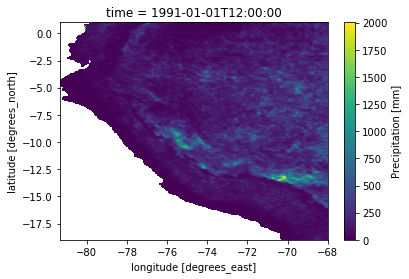

In [19]:
ds.isel(time=120).PP.plot()

In [55]:
%%capture
#===============================
# Funcs for Plottings
#===============================
def nmme_plot(ds, vmin, vmax, levels, shp_outer, cmap=None):
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':16}
    shp_select = shp_outer[shp_outer['ID'] > 0]
    shp = shp_select.geometry
    proj = ccrs.PlateCarree()
    lon_formatter =  LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    cmp = cmap
    cmp = crop_cmap_cmo(cmp,percent=10)
    border_features = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_countries',
                                                   scale='10m',facecolor='none',edgecolor='grey',
                                                   linewidth=0.4)
    
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(16,10), dpi=100, sharey=True, sharex=True,
                           subplot_kw=dict(projection=proj))
    
    for n, (p,axs) in enumerate(zip(ds,ax.flat)):
        axs.set_xticks(np.arange(-90,-30,15), crs=proj)
        axs.set_yticks(np.arange(-50,10,10), crs=proj)
        axs.xaxis.set_major_formatter(lon_formatter)
        axs.yaxis.set_major_formatter(lat_formatter)
        axs.add_feature(border_features,zorder=2)
        axs.set_extent([-82, -46, -20, 5], crs= proj)
        axs.add_feature(cfeature.LAKES)
        axs.add_feature(cfeature.RIVERS)
        axs.add_geometries(shp, proj, edgecolor='green', linewidth=0.2,
                           facecolor='none', zorder=3)
        pls = p.plot.contourf(ax=axs, levels=levels, vmin=vmin, vmax=vmax,   
                              add_colorbar=False, cmap=cmp, transform=proj)
        plx = p.where(p>.4, drop=True).plot.contourf(ax=axs, levels=levels, vmin=vmin, vmax=vmax, hatches=["...."], 
                                                     add_colorbar=False, cmap=cmp, transform=proj)
        axs.grid(linestyle='--',color='gray',alpha=0.5)
        axs.set_aspect('auto')
        axs.set_title('')
        axs.set_ylabel('')
        axs.text(-0.1,1.0, string.ascii_uppercase[n], transform=axs.transAxes,size=14, weight='bold')
    fig.colorbar(pls, orientation='vertical', ax=ax, aspect=20, label='Anomaly Correlation (AC)')

In [183]:
#===============================
# Plot SPI3 trends with OBS
#===============================
def pisco_xy_plot(ds, varname='PP', **kwargs):
    plt.style.use('default')
    fig, ax = plt.subplots(ncols= 2, nrows=1, figsize=(17,4), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':16}
    sns_color='grey'
    dates_rng = pd.date_range('1981-01-01', '2017-02-01', freq='24M')
    proj = ccrs.PlateCarree()
    lon_formatter =  LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    cmp = cmo.cm.speed
    border_features = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_countries',
                                                   scale='10m',facecolor='none',edgecolor='grey',
                                                   linewidth=0.4)
    for n, axs in enumerate(ax.flat):
        pls = ds[varname].mean(['X','Y']).plot(ax=axs, linestyle='-', linewidth=.8, label='PISCO')
        if n==0:
            axs.text(-0.1,0.9, string.ascii_uppercase[n], transform=axs.transAxes,size=16, weight='bold')
            axs.set_xticks(dates_rng)
            axs.set_xticklabels([dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=30, size=8)
            axs.legend(loc='upper right',prop={'size': 10},ncol=2)
            axs.grid(linestyle='--')
            axs.set_ylabel('PISCO Monthly Rainfall (mm)')
        else:
            axs.set_xticks(np.arange(0,360,30))
            axs.set_yticks(np.arange(-30,30,10))
            axs.xaxis.set_major_formatter(lon_formatter)
            axs.yaxis.set_major_formatter(lat_formatter)
#             axs.add_feature(border_features,zorder=2)
#             axs.set_extent([-82, -46, -20, 5], crs= proj)
#             axs.add_feature(cfeature.LAKES)
#             axs.add_feature(cfeature.RIVERS)
#             axs.add_geometries(shp, proj, edgecolor='green', linewidth=0.2,
#                                facecolor='none', zorder=3)
#             pls = ds[varname].plot.contourf(ax=axs, levels=levels, vmin=vmin, vmax=vmax,   
#                                   add_colorbar=False, cmap=cmp, transform=proj)
#             axs.grid(linestyle='--',color='gray',alpha=0.5)
#             axs.set_aspect('auto')
#             axs.set_title('')
#             axs.set_ylabel('')

In [184]:
pisco_xy_plot(ds, varname='PP', title='Selected Point')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f12594c8ea0> (for post_execute):


TypeError: This formatter can only be used with cartopy axes.

TypeError: This formatter can only be used with cartopy axes.

<Figure size 1700x400 with 2 Axes>

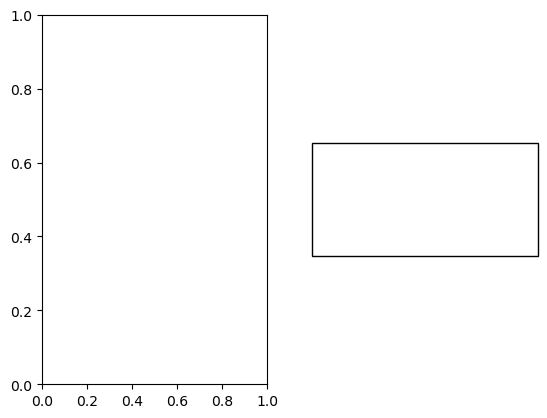

In [187]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax1 = plt.subplot(121)
ax3 = plt.subplot(122, projection=ccrs.PlateCarree())

### **Temporal Analysis**

In [15]:
#----------------------------
# masking with shp
#----------------------------
ds_r = masking_xr(ds, shps)
ds = ds_r.where(ds_r.regions >= 0, drop=True)

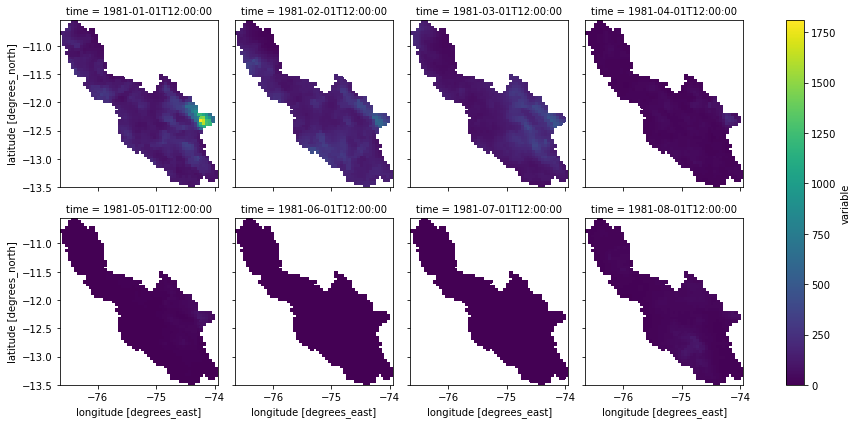

In [16]:
ds.PP.isel(time=slice(0,8)).plot(col='time', col_wrap=4)

### **Temporal Series Mantaro**

In [37]:
#===============================
# Plot SPI3 trends with OBS
#===============================
def nmme_xy_spi3(ds,varname='spi3'):
    fig, ax = plt.subplots(figsize=(17,4),dpi=100)
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':16}
    sns_color='grey'
    ds[varname].mean(['X','Y'], skipna=True).plot(ax=ax, linestyle='-', linewidth=.8, label='Ensemble NMME models')
    ax.set_title('Mantaro Basin',fontdict=font)
    ax.set_ylabel('Standard Precipitation Index 3-months')
    ax.set_xlabel('')
    ax.text(-0.1,0.9, string.ascii_uppercase[0], transform=ax.transAxes,size=16, weight='bold')
    dates_rng = pd.date_range('1980-01-01', '2018-12-01', freq='12M')
    plt.xticks(dates_rng, [dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=30, size=8)
    ax.legend(loc='upper right',prop={'size': 10},ncol=2)
    ax.grid(linestyle='--')

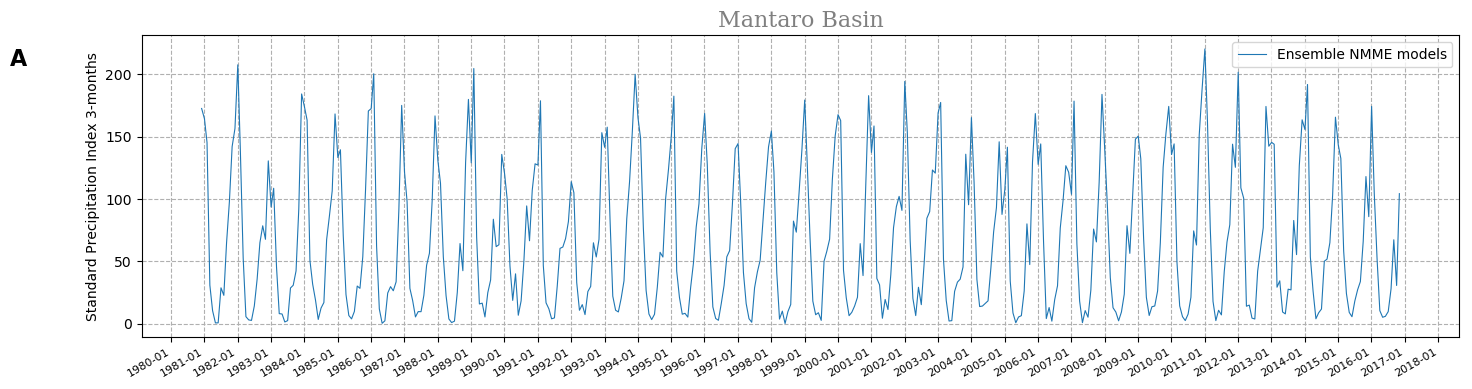

In [38]:
nmme_xy_spi3(ds, varname='PP')

### **Standard Precipitation Index**

In [58]:
fili_ncs_spi3_gamma = [os.path.join(diri_ncs,x) for x in os.listdir(diri_ncs) if 'gamma' in x and x.endswith('.nc')]

In [70]:
ds_spi_gamma = xr.open_mfdataset(fili_ncs_spi3_gamma, concat_dim=None)

In [83]:
ds_spi_gamma.lat

<xarray.DataArray 'lat' (lat: 59)>
array([-10.575001, -10.625001, -10.675001, -10.725001, -10.775001, -10.825001,
       -10.875001, -10.925001, -10.975001, -11.025001, -11.075001, -11.125001,
       -11.175001, -11.225001, -11.275001, -11.325001, -11.375001, -11.425001,
       -11.475001, -11.525001, -11.575001, -11.625001, -11.675001, -11.725001,
       -11.775001, -11.825001, -11.875001, -11.925001, -11.975001, -12.025001,
       -12.075001, -12.125001, -12.175001, -12.225001, -12.275001, -12.325001,
       -12.375001, -12.425001, -12.475001, -12.525001, -12.575001, -12.625001,
       -12.675001, -12.725001, -12.775001, -12.825001, -12.875001, -12.925001,
       -12.975001, -13.025001, -13.075001, -13.125001, -13.175001, -13.225001,
       -13.275001, -13.325001, -13.375001, -13.425001, -13.475001])
Coordinates:
  * lat      (lat) float64 -10.58 -10.63 -10.68 -10.73 ... -13.38 -13.43 -13.48
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          deg

In [81]:
ISOTO = {'lat': -15.61, 'lon': -69.46}
ISOTO_station = ds_spi_gamma.sel(lat=-15, method='backfill')

KeyError: -15

In [72]:
ISOTO = [-15.61, -69.46]

In [71]:
ds_spi_gamma

<xarray.Dataset>
Dimensions:       (lat: 59, lon: 54, time: 432)
Coordinates:
  * lon           (lon) float64 -76.62 -76.57 -76.52 ... -74.07 -74.02 -73.97
  * lat           (lat) float64 -10.58 -10.63 -10.68 ... -13.38 -13.43 -13.48
  * time          (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-01T12:00:00
Data variables:
    spi_gamma_01  (lat, lon, time) float32 dask.array<shape=(59, 54, 432), chunksize=(59, 54, 432)>
    spi_gamma_03  (lat, lon, time) float32 dask.array<shape=(59, 54, 432), chunksize=(59, 54, 432)>
    spi_gamma_06  (lat, lon, time) float32 dask.array<shape=(59, 54, 432), chunksize=(59, 54, 432)>
    spi_gamma_12  (lat, lon, time) float32 dask.array<shape=(59, 54, 432), chunksize=(59, 54, 432)>
Attributes:
    CDI:                       Climate Data Interface version 1.6.2 (http://c...
    Conventions:               CF-1.4
    history:                   Thu May 16 21:22:17 2019: /usr/bin/ncpdq -a la...
    crs:                       +proj=longlat +datum=WG

In [55]:
ds_spi3_gamma = xr.open_dataset('./spi3.nc_spi_gamma_03.nc')

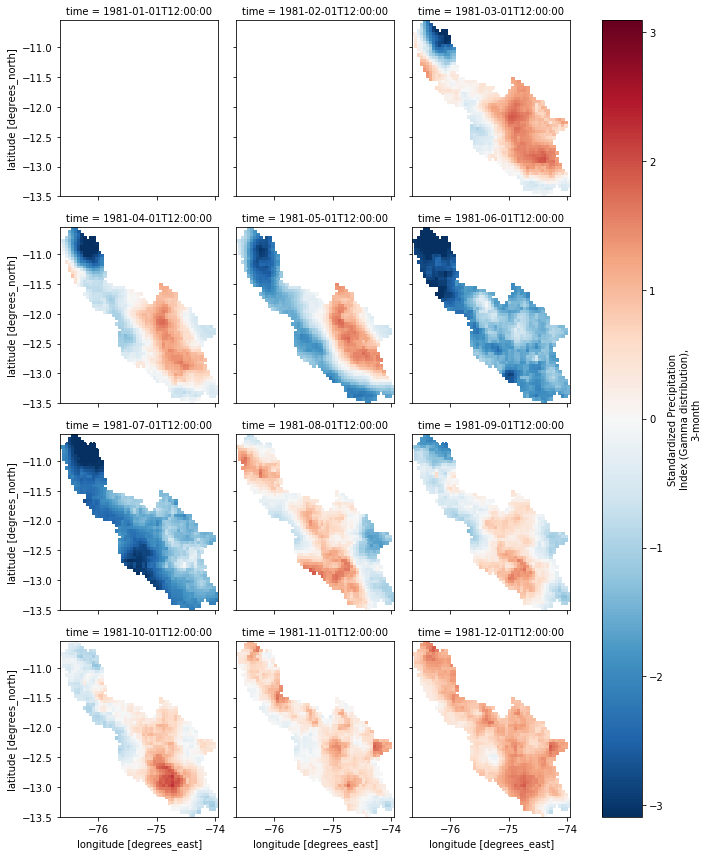

In [57]:
ds_spi3_gamma.isel(time=slice(0,12)).spi_gamma_03.plot(col='time',col_wrap=3)

### **Sea Surface Temperature Anomaly**


In [39]:
def sst_anom(ds):
    clim = ds.groupby('time.month').mean('time', skipna=True)
    anom = ds.groupby('time.month') - clim
    return anom

In [42]:
%%capture
#-----------------------------
# Open and fix calendar time
#-----------------------------
ds2 = xr.open_dataset(fili_ncs[2], decode_cf=False)
ds2 = xr.decode_cf(ds2)
ds2_anom = sst_anom(ds2)

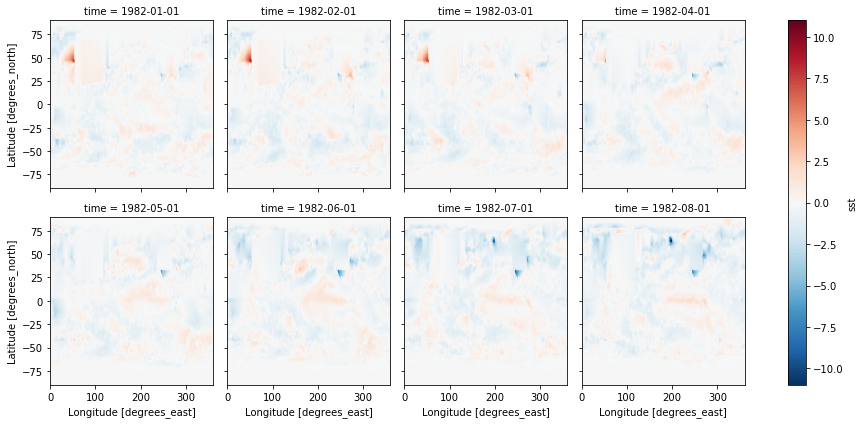

In [45]:
ds2_anom.isel(time=slice(0,8)).sst.plot(col='time', col_wrap=4)

### **Correlation between masking rainfall and global TSM**

In [136]:
def corr_eofs(ds, obs_ds):
    masked_obs_ds = np.ma.masked_invalid(obs_ds.mean(['X','Y'], skipna=True).PP)
    CORR = eofs.tools.standard.correlation_map(masked_obs_ds, ds.sst.data)
    spatial_coords = {'Y':ds.coords['Y'], 'X':ds.coords['X']}
    return xr.Dataset({'corrs': (['Y','X'], CORR)}, coords=spatial_coords)

In [154]:
ds_rainfall = ds.sel(time=slice('1982-01-01','2005-01-01'))
ds_sst = ds2_anom.sel(time=slice('1982-01-01','2005-01-01'))
ds_sst = ds_sst.rename({'lat':'Y', 'lon':'X'})
CORR = corr_eofs(ds_sst, ds_rainfall)

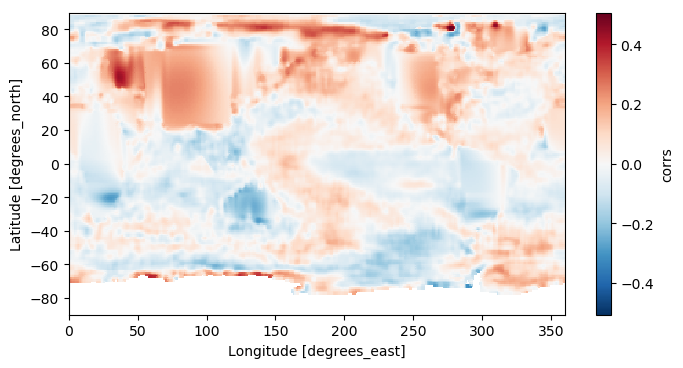

In [161]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
CORR.corrs.plot(ax=ax)